In [210]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
import pickle
import seaborn as sns
import cv2

### Load Model data

In [2]:
x_test = pd.read_pickle('x_testc')
x_train = pd.read_pickle('x_trainc')
y_test = pd.read_pickle('y_testc')
y_train = pd.read_pickle('y_trainc')
rf = pd.read_pickle('rf_no_crop_cv')
xg = pd.read_pickle('xgb_no_crop_cv')
svm = pd.read_pickle('svm_no_crop')

In [207]:
rfp = rf.predict_proba(x_test)
xgbp = xg.predict_proba(np.array(x_test))
svmp = svm.predict_proba(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.2s finished


### Probabilities weighting

    Tried giving weights to the probabilites from each model to get a high accuracy

In [56]:
prob_sum = rfp + xgbp + svmp

In [27]:
acc = []
# loops through different wieghts to give each model
for x in np.linspace(5,15,11):
    for y in np.linspace(5,15,11):
        for z in np.linspace(5,15,11):
            # assigns weights and sums probabilities 
            prob_sum = (.1*x)*rfp + (.1*y)*svmp + (.1*z)*xgbp
            # finds highest prob and creates class pred
            class_pred = prob_sum.argmax()
            # finds acuracy score and puts in a list
            acc.append(accuracy_score(class_pred, y_test))

# finds highest accuracy 
acc.max()

### Accuracy for each facial expression

In [20]:
def expression_acc(exp):
    
    if exp == xg:
        predicted_exp = exp.predict(np.array(x_test))
    else:
        predicted_exp = exp.predict(x_test)

    accu = []
    correct2 = []
    
    #loops through all classes to index each seperately and compare to predicited values
    for v in [0,1,2,3,4,5,6]:
        ind = []
        num = 0
        #loops through y_test to create index of where facial expression occurs in y_test
        for count, i in enumerate(y_test):
            if i == v:
                num += 1
                ind.append(count)
        
        # loops through predicted x_test classes and creates index
        ind1 = []
        num1 = 0
        for count, i in enumerate(predicted_exp):
            if i == v:
                num1 += 1
                ind1.append(count)
        
        # checks to see how many of the predicted indexes are correct
        correct = 0
        for i in ind1:
            if i in ind:
                correct +=1
        
        #appends number correct and accuracy percentage for each class
        correct2.append(correct)
        accu.append(correct/num)
    
    return accu, correct

"""
This function is used to determine per class the accuracy percentage of each model
"""

In [21]:
accu_rf, correct_rf = expression_acc(rf)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.3s finished


In [22]:
accu_xg, correct_xg = expression_acc(xg)

In [24]:
accu_svm, correct_svm = expression_acc(svm)

In [200]:
# creates dataframe from expression_acc function results
class_name = ['Afraid','Angry','Disgust','Happy','Neutral','Sad','Suprised']
df1 = pd.DataFrame(accu_rf)
df1['Model']='Random Forest'
df1['Class']=class_name
df2 = pd.DataFrame(accu_xg)
df2['Model']='XGClassifer'
df2['Class']=class_name
df3 = pd.DataFrame(accu_svm)
df3['Model']='Support Vector Machine'
df3['Class']=class_name

In [208]:
# combines dataframes vertically 
df_com = pd.concat([df1, df2, df3])

In [193]:
# takes average of all individual percentages per class, used for average line in graph
mean_line = h["Percentage"].mean()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


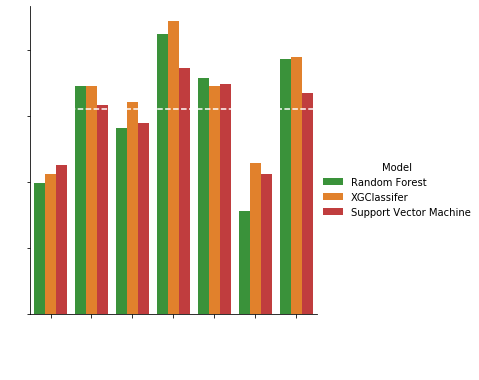

In [205]:
#graph creation
sns.factorplot(x='Class', y=0, hue='Model', data=h, kind='bar', palette=["C2", "C1", "C3"])
plt.axhline(mean_line, ls='--', color = 'white')
plt.xticks(color = 'white', rotation=45)
plt.yticks(color = 'white')
plt.xlabel('Class', color = 'white')
plt.ylabel('', color = 'white')
plt.savefig('Expressions', dpi = 300, transparent = True)